# Bechmark: Vern9 vs IRKGL16 (Float64) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using DiffEqDevTools,BenchmarkTools
using Dates

In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: ThreeBody problem

In [3]:
const μ = parse(Float64,"0.012277471")
#const uμ = 1 - μ

f = (du,u,p,t) -> begin
  
  μ=p[1]
  uμ=1-μ
  @inbounds begin
  # 1 = y₁
  # 2 = y₂
  # 3 = y₁'
  # 4 = y₂'
  D₁ = ((u[1]+μ)^2 + u[2]^2)^(3/2)
  D₂ = ((u[1]-uμ)^2 + u[2]^2)^(3/2)
  du[1] = u[3]+u[2]
  du[2] = u[4]-u[1]
  du[3] = u[4] - uμ*(u[1]+μ)/D₁ - μ*(u[1]-uμ)/D₂
  du[4] = -u[3] - uμ*u[2]/D₁ - μ*u[2]/D₂
  end
end


t₀ = 0.0;
T = parse(Float64,"17.0652165601579625588917206249")
tspan = (t₀,2T)

py0=parse(BigFloat,"-2.00158510637908252240537862224")+0.994
u0=[0.994,0.0,0.0, Float64(py0)]
prob = ODEProblem(f,u0,tspan,[μ])


ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 34.13043312031593)
u0: [0.994, 0.0, 0.0, -1.0075851063790826]

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [4]:
sol0 = @time(solve(prob,Vern9(),abstol=1e-12,reltol=1e-12));

 26.583777 seconds (51.95 M allocations: 2.332 GiB, 8.77% gc time)


In [5]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9138
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          534
Number of rejected steps:                          37

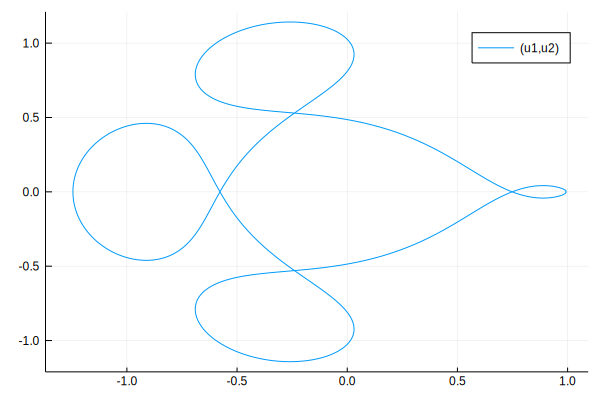

In [6]:
plot(sol0,vars=(1,2))

## Integration with IRKGL16 (Adaptive-step)


In [7]:
(sol1,iters1,steps1)=@time(solve(prob,IRKGL16(),  
                          reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

 13.451170 seconds (13.11 M allocations: 620.325 MiB, 2.39% gc time)


In [8]:
sum(iters1)/sol1.destats.naccept

9.065693430656934

In [9]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  11461
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          21

## Integration with IRKGL162 (Adaptive-step)

In [10]:
(sol2,iters2,steps2)=@time(solve(prob,IRKGL162(),  
                          reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  1.899029 seconds (1.55 M allocations: 72.750 MiB)


In [11]:
sum(iters2)/sol2.destats.naccept

13.459854014598541

In [12]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  15181
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          137
Number of rejected steps:                          21

### Plots IRKGL16

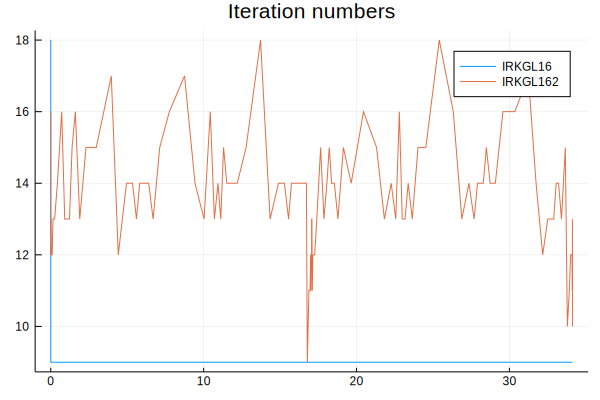

In [13]:
plot(sol1.t[2:end],iters1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iters2[2:end],label="IRKGL162")

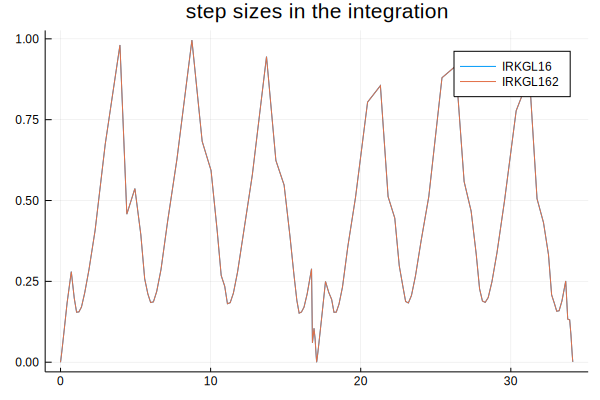

In [14]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

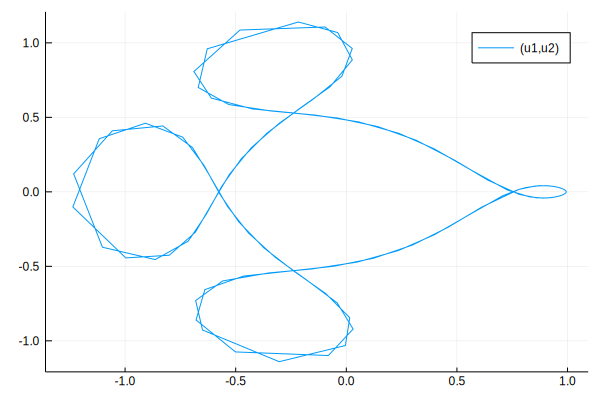

In [15]:
plot(sol1,vars=(1,2))

<a href="#top">Back to the top</a>

## Error in energy

In [16]:
setprecision(BigFloat, 256)
u0128=[0.994,0.0,0.0, py0]
μ128 = parse(BigFloat,"0.012277471")
(typeof(u0128))

Array{BigFloat,1}

In [17]:
function NbodyEnergy(u, mu)
"""    
     3RT-Nbody problem      
"""    
    
    # Implementation

 @inbounds begin
    x = u[1]   # x
    y = u[2]   # y
    px = u[3]  # px
    py = u[4]  # py
        
    umu=1-mu    
 
    r1 = ((x+mu)^2 + y^2)^(1/2)
    r2 = ((x-umu)^2 + y^2)^(1/2)
        
    Energy=(px*px+py*py)/2+px*y-py*x-umu/r1-mu/r2-mu*umu/2    

    
    return(Energy)
    end
        
end

NbodyEnergy (generic function with 1 method)

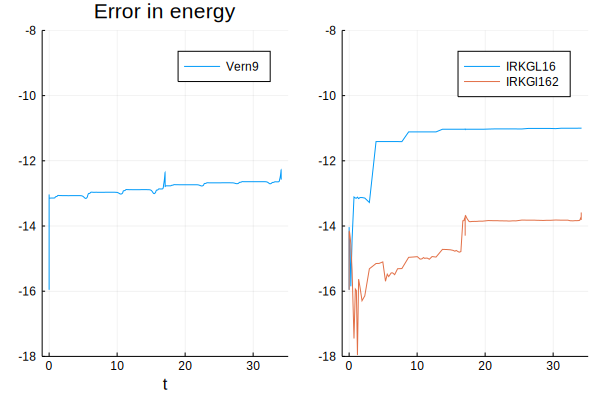

In [18]:
E0=NbodyEnergy(u0128,μ128)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),μ128)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),μ128)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),μ128)/E0-1 for j in 1:length(tlist2)]

ylimit1=-18
ylimit2=-8

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16")
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [19]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(5.196063f-13, 1.00157365f-11, 2.6000266f-14)

## Global error

In [20]:
tspan128=[BigFloat(0.0),2*parse(BigFloat,"17.0652165601579625588917206249")]
test_sol = TestSolution(tspan128,[u0128]);

In [21]:
# Vern9
apr = appxtrue(sol0,test_sol)
#@show sol0[end]
#@show apr.u[end]
@show apr.errors;

apr.errors = Dict(:final => 8.124266874726929283457493530598600045777857303619384765624999999999999692998008e-08)


In [22]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors;

apr.errors = Dict(:final => 1.99164677165194380229933307135600753895232628565281629562377929687500000307002e-06)


In [23]:
err1=Float32(norm(sol1.u[end]-u0128))
err2=Float32(norm(sol2.u[end]-u0128))
(err1,err2)

(6.2809495f-6, 1.0859861f-10)

## Higher Order Algorithms

In [24]:
abstols = 1.0 ./ 10.0 .^ (8:16)
reltols = 1.0 ./ 10.0 .^ (8:16);

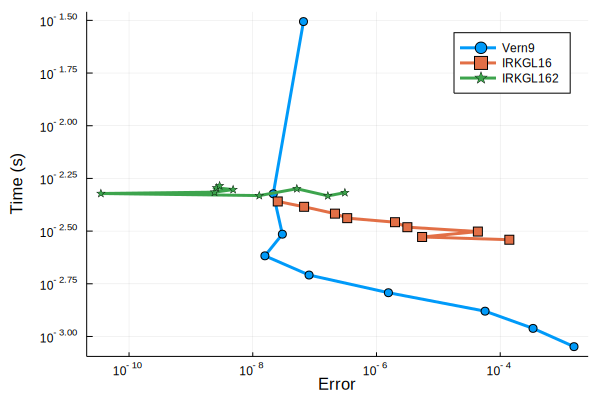

In [25]:
setups = [
    #Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16())   
          Dict(:alg=>IRKGL162())];
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100)
plot(wp)

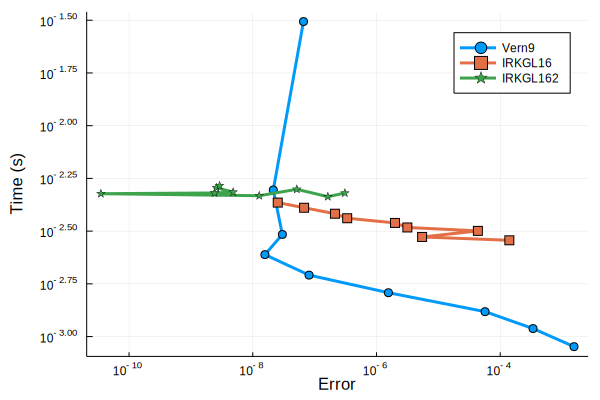

In [26]:
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100)
plot(wp)